In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import os
from scipy import signal, optimize

In [89]:
def load_dataset():
    df_list = []
    
    for directory in ['matrix-mul', 'cublas', 'cuda-tensor']:
        files = os.listdir(directory)
        # Get efimon files
        for i in files:
            if 'efimon' in i:
                df = pd.read_csv(os.path.join(directory, i)).iloc[2:-2]
                name = i.split('-')[1].split('.')[0]
                df["sleep_us"] = int(name)
                df["benchmark"] = directory
                df_list.append(df)
    # Concat everything
    df = pd.concat([i for i in df_list if i is not None])
    return df

In [90]:
df = load_dataset()

# Raw Data

In [91]:
df.head()

,OverallUsage(perc),OverallMemory(perc),OverallPower(W),ClockSM(MHz),ClockMEM(MHz),sleep_us,benchmark
2,0,0,41.858,1357,877,500000,matrix-mul
3,0,0,37.381,1230,877,500000,matrix-mul
4,24,8,37.483,1230,877,500000,matrix-mul
5,24,8,37.477,1230,877,500000,matrix-mul
6,0,0,41.274,1230,877,500000,matrix-mul


<Axes: xlabel='OverallUsage(perc)', ylabel='OverallPower(W)'>

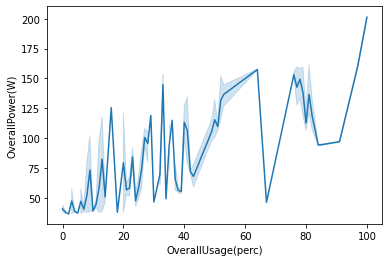

In [92]:
sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)')

<Axes: xlabel='OverallUsage(perc)', ylabel='ClockSM(MHz)'>

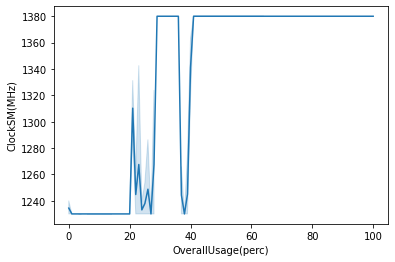

In [93]:
sns.lineplot(df, x='OverallUsage(perc)', y='ClockSM(MHz)' )

<Axes: xlabel='ClockMEM(MHz)', ylabel='OverallPower(W)'>

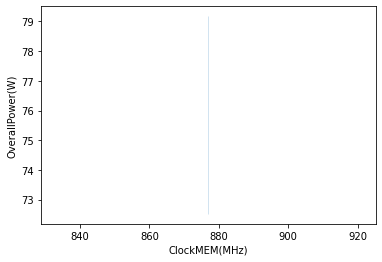

In [82]:
sns.lineplot(df, x='ClockMEM(MHz)', y='OverallPower(W)')

# Filtered

<Axes: xlabel='OverallUsage(perc)', ylabel='MedianOverallPower(W)'>

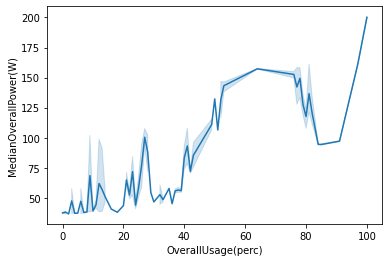

In [83]:
df["MedianOverallPower(W)"] = signal.medfilt(df['OverallPower(W)'], 3)
sns.lineplot(df, x='OverallUsage(perc)', y='MedianOverallPower(W)')

Not effective!

# Try LS

In [123]:
independent_variables = ['OverallUsage(perc)', 'ClockSM(MHz)', 'ClockMEM(MHz)']
A = df[independent_variables].to_numpy()
b = df['OverallPower(W)'].to_numpy()

In [131]:
coeff_1, _ = optimize.nnls(A, b, maxiter=1000)

In [125]:
#sol = optimize.lsq_linear(A, b, max_iter=1000)
#coeff_1 = sol["x"]

In [132]:
coeff_1

array([1.0894753 , 0.03029809, 0.        ])

In [133]:
intercept_1 = coeff_1[-1]

In [134]:
prediction = []
for row in A:
    prediction.append(row.dot(coeff_1) + intercept_1)
df["prediction"] = prediction

<Axes: xlabel='OverallUsage(perc)', ylabel='prediction'>

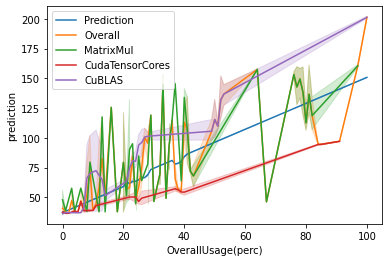

In [135]:
sns.lineplot(df, x='OverallUsage(perc)', y='prediction', label='Prediction')
sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)', label='Overall')
sns.lineplot(df[df['benchmark'] == 'matrix-mul'], x='OverallUsage(perc)', y='OverallPower(W)', label='MatrixMul')
sns.lineplot(df[df['benchmark'] == 'cuda-tensor'], x='OverallUsage(perc)', y='OverallPower(W)', label='CudaTensorCores')
sns.lineplot(df[df['benchmark'] == 'cublas'], x='OverallUsage(perc)', y='OverallPower(W)', label='CuBLAS')